/var/folders/p1/8s9_fqq533b0tkl0412p4btrr53559/T/ipykernel_49124/3488144225.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_data = data[data['input'].str.contains('|'.join(keywords), na=False)].head(100)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence,

       cos_sim_original  cos_sim_extended
count        100.000000        100.000000
mean           0.172558          0.174882
std            0.073265          0.082454
min            0.029583          0.007172
25%            0.127365          0.109620
50%            0.163925          0.166812
75%            0.218754          0.233459
max            0.395500          0.395500


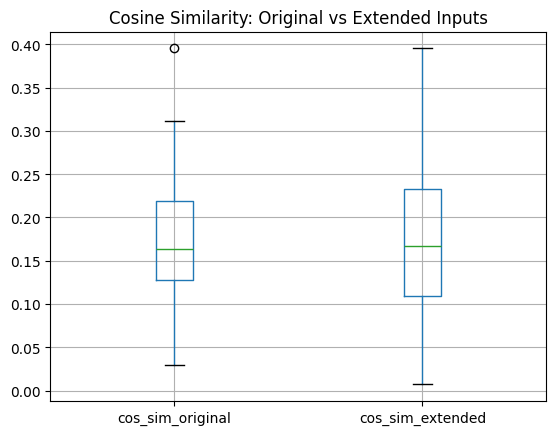

In [11]:
from datasets import load_dataset
import networkx as nx
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import torch

# 1. Загрузка данных
dataset_name = "lavita/ChatDoctor-iCliniq"
graph_path = "/Users/21311064/Downloads/KnowledgeGraph.gexf"

# Загрузка датасета с Hugging Face
dataset = load_dataset(dataset_name)
data = pd.DataFrame(dataset['train'])  # Используем тренировочный набор

# Загрузка графа
graph = nx.read_gexf(graph_path)

# Функция для поиска связанных слов
def get_related_words(word, graph, max_depth=1):
    related = set()
    if word in graph:
        for neighbor in nx.single_source_shortest_path_length(graph, word, cutoff=max_depth):
            related.add(neighbor)
    return related

# 2. Фильтрация датасета
# Найти примеры, содержащие слова из графа
keywords = set(graph.nodes)
filtered_data = data[data['input'].str.contains('|'.join(keywords), na=False)].head(100)

# 3. Настройка модели
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B")

# Генерация ответа модели
def generate_response(input_text):
    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model.generate(inputs["input_ids"], max_new_tokens=50)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# 4. Дополнение input связанных слов
results = []
for _, row in filtered_data.iterrows():
    input_text = row['input']
    answer_text = row['answer_chatdoctor']
    
    # Генерация обычного ответа
    response_original = generate_response(input_text)
    
    # Дополнение связанными словами
    related_words = get_related_words(input_text, graph)
    extended_input = input_text + " " + " ".join(related_words)
    response_extended = generate_response(extended_input)
    
    # Сохранение результатов
    results.append({
        "input": input_text,
        "answer_chatdoctor": answer_text,
        "response_original": response_original,
        "response_extended": response_extended
    })

# 5. Вычисление косинусного сходства
vectorizer = TfidfVectorizer()
similarities = []
for result in results:
    tfidf = vectorizer.fit_transform([result['answer_chatdoctor'], result['response_original'], result['response_extended']])
    cos_sim_original = cosine_similarity(tfidf[0], tfidf[1])[0][0]
    cos_sim_extended = cosine_similarity(tfidf[0], tfidf[2])[0][0]
    similarities.append({"input": result["input"], "cos_sim_original": cos_sim_original, "cos_sim_extended": cos_sim_extended})

# 6. Анализ результатов
similarity_df = pd.DataFrame(similarities)
print(similarity_df.describe())

# Визуализация
import matplotlib.pyplot as plt
similarity_df[['cos_sim_original', 'cos_sim_extended']].boxplot()
plt.title("Cosine Similarity: Original vs Extended Inputs")
plt.show()

In [19]:
results

[{'input': 'Hello doctor,I am trying to conceive but my husband and I did cocaine a week ago. How long should my husband and I wait to safely continue to try to get pregnant? How long until it is out of our system? How long does cocaine stay in sperm? Thanks in advance.',
  'answer_chatdoctor': '1) Cocaine use can affect fertility by causing male infertility due to decreased sperm motility and morphology as well as increased abnormal semen parameters (especially pH). However, there is insufficient evidence to suggest that cocaine causes significant changes in female fertility.2) It is not clear how long cocaine remains in semen or blood after use. Therefore, it is difficult to say exactly when it will be completely gone from your husbands body.3) There is no data regarding the amount of time that couples need to abstain from sexual activity before attempting conception.4) In conclusion, if you want to become pregnant, then you should avoid coke for at least three months before trying t

In [18]:
get_related_words("Fungal infection", graph)

{' dischromic _patches',
 ' nodal_skin_eruptions',
 ' skin_rash',
 'Fungal infection',
 'itching',
 'nan'}

In [30]:
similarity_df

,input,cos_sim_original,BioGPT,BioGPT1,MyGraphBig,MyGraphBioNlpBlueBert,BioMedRoberta
0,"Hello doctor,I am trying to conceive but my hu...",0.573072,0.592558,0.550700,0.597450,0.565843,0.582436
1,"Hello doctor,I just got one side of my wisdom ...",0.575572,0.658850,0.581399,0.431733,0.523732,0.460454
2,"Hi doctor,My last USG report showed intrauteri...",0.531786,0.682457,0.485912,0.398070,0.534911,0.581882
3,"Hello doctor,My body is getting severe itching...",0.484119,0.628116,0.563719,0.697335,0.600541,0.727750
4,"Hi doctor,I am a 25-year-old male. I do not ha...",0.437825,0.490177,0.459956,0.523470,0.612777,0.677439
...,...,...,...,...,...,...,...
96,"Hi doctor,I am a 45 year old male. I had an ac...",0.454024,0.533336,0.625965,0.530512,0.592153,0.544533
97,"Hello doctor,I am having pain shooting down fr...",0.570615,0.678250,0.614509,0.426436,0.650843,0.751497
98,"Hello doctor,I am in love with my relative. We...",0.474025,0.572678,0.625606,0.698794,0.687255,0.685873
99,"Hi doctor,I am 9 months pregnant, and I have s...",0.438029,0.580068,0.681865,0.537236,0.534128,0.602345
